### **Implementing LSTM using inbuilt nn.LSTM** -

In [1]:
import torch
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_window_size , hidden_size, num_layers, batch_first = True):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        #defining an LSTM layer
        self.lstm = nn.LSTM(input_size = input_window_size,
                            hidden_size= hidden_size ,
                            num_layers=num_layers,
                            batch_first = batch_first)

        #define the output layer
        self.fc = nn.Linear(hidden_size , 1)

    def forward(self ,x):
        #initializing hidden_state  with zeros
        h0 = torch.zeros(self.num_layers , x.size(0) , self.hidden_size).to(x.device)

        #initializing cell state with zeros
        c0 = torch.zeros(self.num_layers , x.size(0) , self.hidden_size).to(x.device)


        #forward LSTM
        out,_ = self.lstm(x , (h0 , c0))

        #decoding the hidden_state of last time step
        out = self.fc(out[:,-1, :])

        return out



In [2]:
#Printing lstm model with nn.module

#for example lets take
input_window_size = 10
hidden_size = 60
num_layers = 4

model = LSTMModel(input_window_size , hidden_size , num_layers)
print(model)

LSTMModel(
  (lstm): LSTM(10, 60, num_layers=4, batch_first=True)
  (fc): Linear(in_features=60, out_features=1, bias=True)
)


# Building LSTM from sratch -:
1) Tensors :A tensor is multi-dimensional array , and in pytorch , tensors are used to  represent data or model weight.
2)Variable and parameter: Variable used in older version  to wrap tensors and track gradients. In newer versions  , variable is depricated, and tensors with requires_grad = True  are used instead.
Paramter is specifically designed to be part of the model.When you assign  a tensor as nn.Parameter  with a module (like we have used here), pytorch automatically registers as the  model parameters.It means it will be included in the model's parameter() iterator.






# **Forward Function :**
This functions defines how the LSTM Cell  processes the input at each time stamp and updates its hidden state and cell accordingly.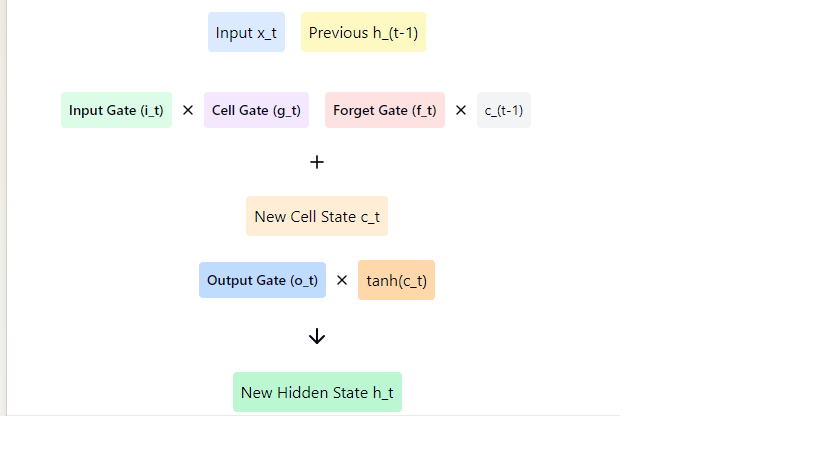

# **Input Components**
h_prev, c_prev = hidden
Previous hidden state and cell state

# **Inputs:**
x_t (current input)
h_(t-1) (previous hidden state)
c_(t-1) (previous cell state)


# **Gates Computation**
Input Gate
i_t = σ(x @ W_ii.T + h_prev @ W_hi.T + b_i)
Forget Gate
f_t = σ(x @ W_if.T + h_prev @ W_hf.T + b_f)
Cell Gate
g_t = tanh(x @ W_ig.T + h_prev @ W_hg.T + b_g)
Output Gate
o_t = σ(x @ W_io.T + h_prev @ W_ho.T + b_o)

# **State Updates**
c_t = f_t * c_prev + i_t * g_t
New cell state: forget old info + add new info
h_t = o_t * torch.tanh(c_t)
New hidden state: output gate controls what to expose

In [32]:
!#We are taking similiar two layers, hidden_size = 50 and input_window_size = 10


import torch
import torch.nn as nn

class LSTMCell(nn.Module):
  def __init__(self , input_size , hidden_size):

      super(LSTMCell , self).__init__()
      self.hidden_size = hidden_size
      self.input_size = input_size

      #Making input gate components
      self.Wii = nn.Parameter(torch.Tensor(hidden_size , input_size))
      self.Whi = nn.Parameter(torch.Tensor(hidden_size , hidden_size))
      self.bi = nn.Parameter(torch.Tensor(hidden_size))



      #Forget gate components
      self.Wif = nn.Parameter(torch.Tensor(hidden_size , input_size))
      self.Whf = nn.Parameter(torch.Tensor(hidden_size , hidden_size))
      self.bf = nn.Parameter(torch.Tensor(hidden_size))


      #cell gate components
      self.Wig = nn.Parameter(torch.Tensor(hidden_size , input_size))
      self.Whg = nn.Parameter(torch.Tensor(hidden_size , hidden_size))
      self.bg = nn.Parameter(torch.Tensor(hidden_size))


      #output gate Components
      self.Wio = nn.Parameter(torch.Tensor(hidden_size , input_size))
      self.Who = nn.Parameter(torch.Tensor(hidden_size , hidden_size))
      self.bo = nn.Parameter(torch.Tensor(hidden_size))

      self.init_weights()


  def init_weights(self):  #this function initializes the weight / basis of the parameters.
    for param in self.parameters():
      nn.init.uniform_(param,-0.1, 0.1)


  def forward(self , x, hidden):
    h_prev , c_prev = hidden

    it = torch.sigmoid(x @ self.Wii.T + h_prev @ self.Whi.T + self.bi)
    ft = torch.sigmoid(x @ self.Wif.T + h_prev @ self.Whf.T + self.bf)
    gt = torch.tanh(x @ self.Wig.T + h_prev @ self.Whi.T + self.bg)
    ot = torch.sigmoid(x @ self.Wio.T + h_prev @ self.Who.T +self.bo)
    ct = ft* c_prev + it *gt
    ht = ot * torch.tanh(ct)

    return ht , (ht, ct)

LSTM:


In [33]:
class LSTM(nn.Module):
  def __init__(self ,input_size , hidden_size , num_layers):
    super(LSTM , self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm_cells = nn.ModuleList([LSTMCell(input_size , hidden_size) if i ==0
                                     else LSTMCell(hidden_size , hidden_size)
                                     for i in range(num_layers)])

    self.fc = nn.Linear(hidden_size, 1)


  def forward(self , x):
    batch_size  , seq_len, _ = x.size()
    h = [torch.zeros(batch_size,  self.hidden_size).to(x.device) for _ in range(self.num_layers)]
    c = [torch.zeros(batch_size , self.hidden_size).to(x.device) for _ in range(self.num_layers)]

    for t in range(seq_len):
      xt = x[:, t , :]
      for i ,cell in enumerate(self.lstm_cells): #Pass Through LSTM Cells
          h[i], (h[i],c[i]) = cell(xt, (h[i] , c[i]))
          xt = h[i]

      out = self.fc(h[-1]) #A fully connected (linear) layer that maps the last hidden state (h[-1]) from the final LSTM layer to a single output.
      return out



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
input_size = 10
hidden_size = 50
num_layers = 2

model = LSTM(input_size , hidden_size , num_layers)
print(model)

sample_input = torch.rand(1,5 , input_size)
sample_input = sample_input.to(device)
output = model(sample_input)

LSTM(
  (lstm_cells): ModuleList(
    (0-1): 2 x LSTMCell()
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
